# Modeling Pass The Pigs

After hours of playing this game at a house-warming party, and again playing it for class, I decided why not figure out a way I can be the best there ever was.

The information on how to play and what the game is can be found here:
https://en.wikipedia.org/wiki/Pass_the_Pigs.
Essentially this game is dice with pigs instead of dice.

## Strategy

* Get input data from my class
    * Look for probabilities of outcomes for each dice
    * Maybe look at distributions for outcomes of each dice roll
* Simulate
* ??



## Read the Data

First we read in the data from all teams in my class.

In [1]:
import pandas as pd

data = pd.read_csv("pass_the_pigs.csv")
data

,dot,dot_f,razorback,trotter,snouter,leaning_jowler,other
0,38,52,45,17,2,0,1
1,19,32,32,4,3,0,0
2,14,26,20,7,3,0,2
3,14,21,25,5,1,0,3
4,15,27,40,13,5,0,0
5,32,45,43,10,9,0,0
6,16,24,20,6,1,1,2
7,16,50,53,13,4,1,0
8,24,23,17,7,0,3,0
9,13,25,38,12,3,2,4


Even though the data looks a bit uneven, we find the percentage that each outcome was found as well as the standard deviation for each outcome for each class.

In [2]:
total_rolls = data.values.sum()

#keys for shorthand, I may want to actually type these out in future or just use a basic conversion
keys = {
    'dot' : 'dot',
    'dot_f' : 'nod',
    'razorback' : 'rzb',
    'trotter' : 'ttr',
    'snouter' : 'str',
    'leaning_jowler' : 'ljw',
    'other' : 'otr'
}

#find percentages for each row to calculate standard deviation
cols = list(keys.keys())
shortcut = list(keys.values())

pct_data = data
pct_data[cols] = data[cols].div(data[cols].sum(axis=1), axis=0)

pct_std = pd.DataFrame([pct_data[cols].std()])
total_pct = pd.DataFrame([pct_data[cols].mean()])

pct_std.rename(columns=keys, inplace='True')
total_pct.rename(columns=keys, inplace='True')

# input of relative frequencies from wikipedia
wiki_pct = pd.DataFrame.from_dict({
    'dot' : [.349],
    'nod' : [.302],
    'rzb' : [.224],
    'ttr' : [.088],
    'str' : [.030],
    'ljw' : [.0061],
    'otr' : [.0009]
})

In [3]:
#Standard Deviations of each proportion
pct_std

,dot,nod,rzb,ttr,str,ljw,otr
0,0.057471,0.03772,0.055139,0.026299,0.019023,0.013052,0.017999


In [4]:
#total proportions or the average proportion of values
total_pct

,dot,nod,rzb,ttr,str,ljw,otr
0,0.203947,0.32675,0.328447,0.089408,0.027842,0.007522,0.016084


https://en.wikipedia.org/wiki/Pass_the_Pigs#Relative_frequencies

In [5]:
#relative frequencies from Wikipedia 
wiki_pct

,dot,nod,rzb,ttr,str,ljw,otr
0,0.349,0.302,0.224,0.088,0.03,0.0061,0.0009


What we have now are sampling distributions of the proportions from a sample of size 14 in DataFrames.

## Strategies

A few possible strategies to look at (these may be updated):

    1) Roll until we hit 100
    2) Roll until we hit 20
    3) Roll until the EV is negative
    4) ...

## Expected Values

First, we take a look at the expected value for rolling two pigs with a given score. This is a combination of score and probability. This should also inform a possible strategy for simulation. https://en.wikipedia.org/wiki/Pass_the_Pigs#Scoring

In [33]:
scores = {
        'dot' : 1,
        'nod' : 1,
        'rzb' : 5,
        'ttr' : 5,
        'str' : 10,
        'ljw' : 15,
        'otr' : 0
    }

def score(r1, r2, current_score=0):
    
    score = 0
    if r1 == r2:
        if r1 == 'dot' or r1 == 'nod':
            score = 1
        else:
            score = scores[r1] * 4
    else:
        if 'dot' in (r1+r2) and 'nod' in (r1+r2):
            score = -1 * current_score
        else:
            score = max(scores[r1], scores[r2])
    return score
            
def expected_value(pct,current_score=0):
    total_score = 0

    #treat this as a global -- maybe change for style later
    for c1 in shortcut:
        for c2 in shortcut:
            total_score += score(c1,c2,current_score) * (pct[c1][0] * pct[c2][0])
    return total_score

expected_value(total_pct, 0)
        


5.85151971969931

## Defining Strategies

1) Roll until we hit 100 (we win)

2) Roll until we hit an arbitrary number (stop_at_n)

In [7]:
def stop_at_n(current_score, n=20, pct=total_pct):
    return current_score >= n

3) Roll until expected value is zero or negative (not used)

In [8]:
def ev_strat(current_score, n=0, pct=total_pct):
    return expected_value(pct,current_score) > 0


In [9]:
cur = 0
while expected_value(total_pct,cur) > 0:
    cur +=1
print(f'rolls until EX = 0: {cur}')

rolls until EX = 0: 43


## Simulation

Let's make a simulation employing each strategy

In [10]:
import numpy as np

def roll_pigs(pct=total_pct, current_score=0):
    # for scoring
    sim_pct = pct.cumsum(axis = 1)
    
    #determine the rolls 
    [roll1, roll2] = ['','']
    #use a uniform distribution opposite of the cumulative sum s.t. we get a type of roll
    [rand1, rand2] = [np.random.uniform(), np.random.uniform()]
    for col in shortcut:
        if rand1 < sim_pct[col][0] and roll1 == '':
            roll1 = col
        if rand2 < sim_pct[col][0] and roll2 == '':
            roll2 = col
    return score(roll1, roll2, current_score)

def simulation_run(strat, n=20, pct=total_pct, logs=False):
    #note-to-self strat.call()
    
    turns = 0 #let's count the number of turns it takes to reach 100
    
    total_score = 0
    
    while total_score <= 100:
        turns += 1
        turn_score = 0
        while not strat(turn_score, n=n, pct=pct):
            current_score = roll_pigs(pct=pct, current_score=turn_score)
            turn_score += current_score
            if current_score < 0:
                break
        if logs:
            print(f'turn: {turn_score}\t total:{total_score}')
        total_score += turn_score
        
    return turns



print(simulation_run(stop_at_n, logs=True))

turn: 0	 total:0
turn: 20	 total:0
turn: 20	 total:20
turn: 21	 total:40
turn: 25	 total:61
turn: 20	 total:86
6


In [11]:
def monte_carlo(m=100,strat=stop_at_n, n=20, pct=total_pct):
    results = []
    for i in range(0,m):
        results.append(simulation_run(strat,pct=pct, n=n))
    return results

Let's try the simulation for 1000 runs of the safe strategy

In [12]:
results = monte_carlo(m=1000,strat =stop_at_n, n=20)
results[0:10]

[8, 6, 6, 4, 9, 5, 9, 5, 9, 11]

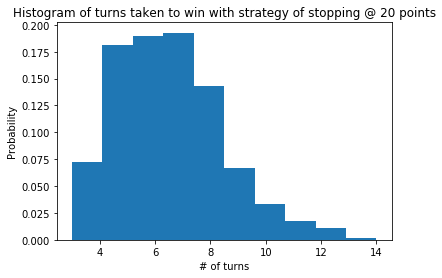

In [14]:
import matplotlib.pyplot as plt
plt.hist(results,density = True, bins= 10)
plt.xlabel('# of turns')
plt.ylabel('Probability')
plt.title('Histogram of turns taken to win with strategy of stopping @ 20 points')
plt.show()

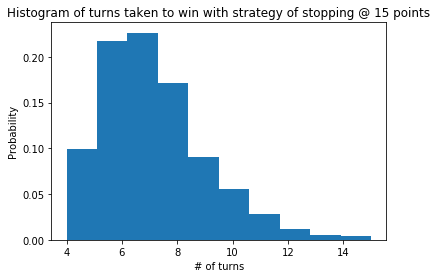

In [15]:
results = monte_carlo(m=1000,strat=stop_at_n, n=15)

plt.hist(results, density = True, bins= 10)
plt.xlabel('# of turns')
plt.ylabel('Probability')
plt.title('Histogram of turns taken to win with strategy of stopping @ 15 points')
plt.show()

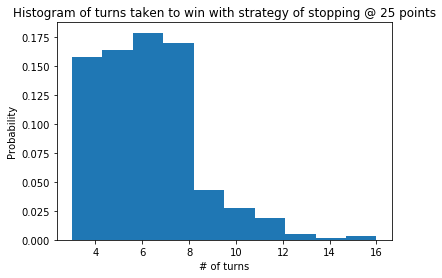

In [16]:
results = monte_carlo(m=1000,strat=stop_at_n,n=25)

plt.hist(results, density =True, bins= 10)
plt.xlabel('# of turns')
plt.ylabel('Probability')
plt.title('Histogram of turns taken to win with strategy of stopping @ 25 points')
plt.show()

In [17]:
avg_turns = []
std_turns = []

rng = range(15,30)

for i in rng:
    print(f'calcuating {i}...')
    cur_results = monte_carlo(m=500,strat=stop_at_n,n=i)
    cur_mean = np.mean(cur_results)
    cur_std = np.std(cur_results)
    avg_turns.append(cur_mean)
    std_turns.append(cur_std)
    print(f'mean of {i}: {cur_mean}\n')
    
avg_turns

calcuating 15...
mean of 15: 7.338

calcuating 16...
mean of 16: 7.036

calcuating 17...
mean of 17: 6.75

calcuating 18...
mean of 18: 6.77

calcuating 19...
mean of 19: 6.766

calcuating 20...
mean of 20: 6.716

calcuating 21...
mean of 21: 6.422

calcuating 22...
mean of 22: 6.344

calcuating 23...
mean of 23: 6.374

calcuating 24...
mean of 24: 6.176

calcuating 25...
mean of 25: 6.428

calcuating 26...
mean of 26: 6.312

calcuating 27...
mean of 27: 6.02

calcuating 28...
mean of 28: 6.234

calcuating 29...
mean of 29: 6.112



[7.338,
 7.036,
 6.75,
 6.77,
 6.766,
 6.716,
 6.422,
 6.344,
 6.374,
 6.176,
 6.428,
 6.312,
 6.02,
 6.234,
 6.112]

Text(0.5, 0, 'score to stop at')

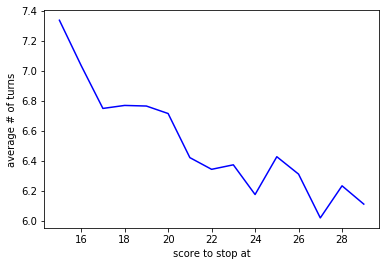

In [18]:
plt.plot(rng,avg_turns, color ='blue')

plt.ylabel('average # of turns')
plt.xlabel('score to stop at')

Text(0.5, 0, 'score to stop at')

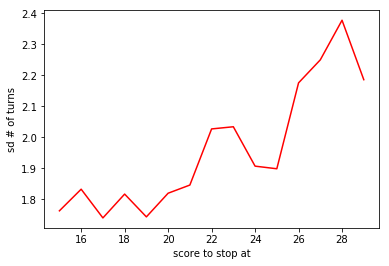

In [19]:
plt.plot(rng,std_turns, color ='red')

plt.ylabel('sd # of turns')
plt.xlabel('score to stop at')

In [20]:
avg_turns = []
std_turns = []

rng = range(25,45)

for i in rng:
    print(f'calcuating {i}...')
    cur_results = monte_carlo(m=500,strat=stop_at_n,n=i)
    cur_mean = np.mean(cur_results)
    cur_std = np.std(cur_results)
    avg_turns.append(cur_mean)
    std_turns.append(cur_std)
    print(f'mean of {i}: {cur_mean}\n')
    
avg_turns

calcuating 25...
mean of 25: 6.214

calcuating 26...
mean of 26: 6.222

calcuating 27...
mean of 27: 6.236

calcuating 28...
mean of 28: 6.116

calcuating 29...
mean of 29: 6.156

calcuating 30...
mean of 30: 6.308

calcuating 31...
mean of 31: 5.828

calcuating 32...
mean of 32: 5.684

calcuating 33...
mean of 33: 5.764

calcuating 34...
mean of 34: 5.866

calcuating 35...
mean of 35: 5.882

calcuating 36...
mean of 36: 6.102

calcuating 37...
mean of 37: 6.178

calcuating 38...
mean of 38: 6.566

calcuating 39...
mean of 39: 6.194

calcuating 40...
mean of 40: 6.618

calcuating 41...
mean of 41: 6.664

calcuating 42...
mean of 42: 6.608

calcuating 43...
mean of 43: 6.344

calcuating 44...
mean of 44: 6.14



[6.214,
 6.222,
 6.236,
 6.116,
 6.156,
 6.308,
 5.828,
 5.684,
 5.764,
 5.866,
 5.882,
 6.102,
 6.178,
 6.566,
 6.194,
 6.618,
 6.664,
 6.608,
 6.344,
 6.14]

Text(0.5, 0, 'score to stop at')

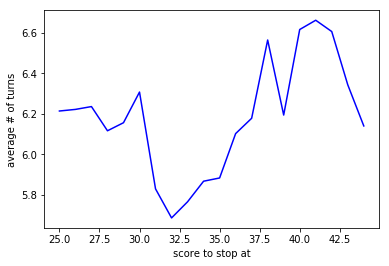

In [21]:
plt.plot(rng,avg_turns, color = 'blue')
plt.ylabel('average # of turns')
plt.xlabel('score to stop at')

Text(0.5, 0, 'score to stop at')

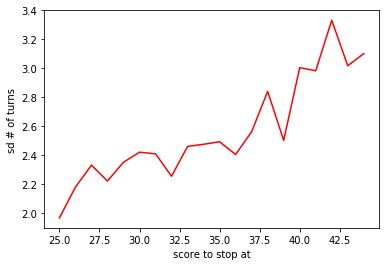

In [22]:
plt.plot(rng,std_turns, color = 'red')
plt.ylabel('sd # of turns')
plt.xlabel('score to stop at')

## A "Best" Strategy

From our results, the "score to stop at" with the lowest mean (the best strategy) would be #32. Although from our simulation, the variance increases as the score to stop at increases. Thus although this may be an empirically ideal strategy to get consistently the lowest number of turns, it might not mean you win the most. This is worth further investigation -- possibly using game theory.

It's worth noting that Pass the Pigs is a game to be played not on one's own but against another team. Now this adds another wrinkle. Yes, The goal is still relatively the same -- in that a player wants to reach 100 points faster than their opponent, and the strategy a player may employ could be dependent on the game state. For example, if player 1 is at 50 points but player 2 is at 90 points, player 1 may want to eploy a higher risk, higher reward strategy such that they have a chance to win.

The idea then, is to employ some game theory in making our decisions.

## A Dynamic Strategy

Let's assume around 32 points is a good stopping point to begin with -- in that on balance, it is the most efficient strategy.

Intuitively then, we would assume that if the deficeit between you and your opponent is greater then the number to stop at and save would be bigger, whereas if you were ahead of your opponent you would probably take less risks.

TODO:
* Find E(X) for points in a turn given a strategy
* Write a new strategy functoin

In [58]:
pct = total_pct

# probabilities of each outcome
outcomes_prob = {
    'dot' : pct['dot'][0] * pct['nod'][0],
    'nod' : pct['dot'][0] * pct['nod'][0],
    '2dot' : pct['dot'][0] * pct['dot'][0],
    '2nod' : pct['nod'][0] * pct['nod'][0],
    '2rzb'   : pct['rzb'][0] * pct['rzb'][0],
    'rzb'    : pct['rzb'][0] * (pct['dot'] + pct['nod']) * 2,
    '2ttr'   : pct['ttr'][0] * pct['ttr'][0],
    'ttr'    : pct['ttr'][0] * (pct['dot'] + pct['nod'] + pct['rzb']) * 2,
    '2str'   : pct['str'][0] * pct['str'][0],
    'str'    : pct['str'][0] * (1 - pct['otr'] - pct['ljw'] - pct['str']) * 2,
    '2ljw'   : pct['ljw'][0] * pct['ljw'][0],
    'ljw'    : pct['ljw'][0] * (1 - pct['ljw'] - pct['otr']) * 2,
    'otr'    : pct['otr'][0] * 2 - (pct['otr'][0] * pct['otr'])
}

#expected value for a turn given a goal of points for a turn
# TODO FIX THIS
def EX_turn(stop_pt=20, pct=total_pct, current_score=0):
    print(current_score)
    total_score = current_score
    
    #treat this as a global -- maybe change for style later
    for c1 in shortcut:
        for c2 in shortcut:
            dbl = ""
            if(c1 == c2): #if we've rolled a double
                dbl = "2"
            p = outcomes_prob[
                dbl 
                + list(scores.keys())[
                    list(scores.values()).index(max(scores[c1], scores[c2]))
                ]]
            turn_score = total_score + score(c1,c2,total_score)
            if current_score != 0:
                if turn_score >= stop_pt or turn_score <= 0:
                    return (total_score + turn_score)
                else:
                    return p * EX_turn(stop_pt, pct, current_score=turn_score)
            else:
                print(f'r1: {c1} r2: {c2}\ttotal: {current_score}\tturn: {turn_score}')
                total_score += p * EX_turn(stop_pt, pct, current_score=turn_score)

    return total_score
                

# if expected value is too hard, assume opponent gets stop value
# and use a geometric distribution to see how many turns it would
# take to fail
def fail_strat(n=20, pct=total_pct):
    # maybe use expected turns before failure
    # as a function of expected turns to success
    f_prob = outcomes_prob['dot'] + outcomes_prob['nod']
    turns = n/expected_value(pct)
    p = pow(1-(1-f_prob),turns)
    mean = 1/f_prob
    return (p,mean,turns)
    
fail_strat()

(0.0010197984879532454, 7.503033052185397, 3.4179155087984108)